# Тест симуляции
Переключай MODE: `empirical` / `theoretical`.
POLICY: `manual` / `auto_counter` / `auto_forecast`.


In [10]:
import sys
from pathlib import Path

project_root = Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

FILE_PATH = project_root / 'Data Set 2. Хакатон 26.02.2026.csv'
print('FILE_PATH =', FILE_PATH)


FILE_PATH = C:\Users\REDMI\Downloads\herd_sim_project_v4\Data Set 2. Хакатон 26.02.2026.csv


In [11]:
import csv
from cows_with_death import load_active_cows, init_empirical_data, get_empirical_lists, get_max_date_from_file
from herd_sim.samplers import EmpiricalDiscreteSampler, build_theoretical_samplers_from_empirical
from herd_sim.simulation import ModelConfig
from herd_sim.monte_carlo import MonteCarloRunner


In [12]:
cows = load_active_cows(str(FILE_PATH))
print('Active cows:', len(cows))

with open(FILE_PATH, mode='r', encoding='utf-8-sig') as f:
    rows = list(csv.DictReader(f, delimiter=';', quotechar='"'))
start_date = get_max_date_from_file(rows)
print('start_date =', start_date)

init_empirical_data(str(FILE_PATH))
ages, dtd, sp = get_empirical_lists()
print('Empirical sizes:', len(ages), len(dtd), len(sp))


Active cows: 1626
start_date = 2026-02-25
Empirical sizes: 632 101 525


In [13]:
MODE = 'empirical'      # 'empirical' | 'theoretical'
POLICY = 'manual' # 'manual' | 'auto_counter' | 'auto_forecast'

DAYS = 365 * 3
RUNS = 100
CENTRAL = 0.95

RECORD_MONTHLY = False
N_JOBS = 12
LEAD_TIME_DAYS = 90

manual_plan = []


In [14]:
if MODE == 'empirical':
    age_sampler = EmpiricalDiscreteSampler(list(ages))
    sp_sampler  = EmpiricalDiscreteSampler(list(sp))
    dtd_sampler = EmpiricalDiscreteSampler(list(dtd))
else:
    age_sampler, sp_sampler, dtd_sampler = build_theoretical_samplers_from_empirical(ages, sp, dtd)

cfg = ModelConfig(
    age_first_insem_days=age_sampler,
    service_period_days=sp_sampler,
    conception_to_dry_days=dtd_sampler,
    min_first_insem_age_days=365,
    gestation_lo=275,
    gestation_hi=280,
    gestation_mu=277.5,
    gestation_sigma=5.0,
    population_regulation=0.5 # вероятность "выбытия" (регулирование количество выбытия (продажа, смерть, брак)) от 0 до 1
)


In [15]:
runner = MonteCarloRunner(base_herd=cows, cfg=cfg, start_date=start_date, file_path=str(FILE_PATH))
bands = runner.run(
    days=DAYS,
    runs=RUNS,
    central=CENTRAL,
    manual_purchase_plan=manual_plan,
    policy=POLICY,
    record_monthly=RECORD_MONTHLY,
    n_jobs=N_JOBS,
    lead_time_days=LEAD_TIME_DAYS,
)
print('Done. central =', bands.central)
print('Purchases run0 auto_counter:', bands.purchase_logs[0].auto_counter[:5])
print('Purchases run0 auto_forecast:', bands.purchase_logs[0].auto_forecast[:5])


Done. central = 0.95
Purchases run0 auto_counter: []
Purchases run0 auto_forecast: []


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def to_df(rows):
    return pd.DataFrame(rows, columns=['date','median','low','high']).set_index('date')

df_milking = to_df(bands.series['milking'])
df_dry = to_df(bands.series['dry'])
df_heifer = to_df(bands.series['heifer'])
df_preg_heifer = to_df(bands.series['preg_heifer'])
df_dim = to_df(bands.series['avg_dim'])
df_culled = to_df(bands.series["culled"])


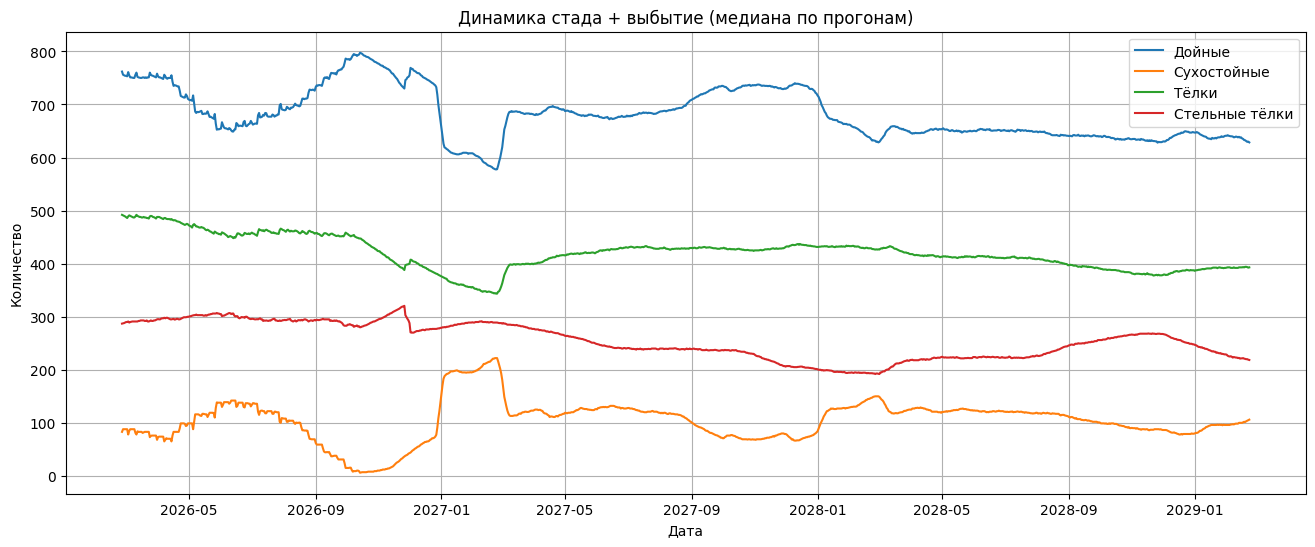

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(df_milking.index, df_milking["median"], label="Дойные")
plt.plot(df_dry.index, df_dry["median"], label="Сухостойные")
plt.plot(df_heifer.index, df_heifer["median"], label="Тёлки")
plt.plot(df_preg_heifer.index, df_preg_heifer["median"], label="Стельные тёлки")
# plt.plot(df_culled.index, df_culled["median"], label="Выбытие (за период)")  # день/месяц

plt.title("Динамика стада + выбытие (медиана по прогонам)")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.legend()
plt.grid(True)
plt.show()

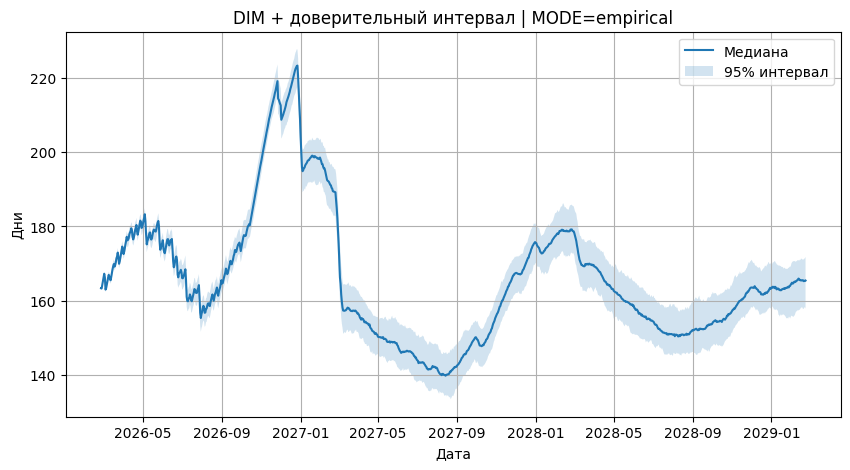

In [18]:
plt.figure(figsize=(10,5))
plt.plot(df_dim.index, df_dim['median'], label='Медиана')
plt.fill_between(df_dim.index, df_dim['low'], df_dim['high'], alpha=0.2, label=f'{int(CENTRAL*100)}% интервал')
plt.title(f'DIM + доверительный интервал | MODE={MODE}')
plt.xlabel('Дата'); plt.ylabel('Дни')
plt.legend(); plt.grid(True); plt.show()
